# UVA-ARC: HDF5 + HSDS tutorial

We describe in this document how to interface HSDS to access environmental data from UVA RC cluster. Examples in Python and R are provided with a commentary section.

## 0. Import dependencies

In [1]:
# First, install the packages we will use
!pip install numpy matplotlib seaborn h5pyd rpy2 luminol

In [2]:
# Then, load the necessary modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rpy2.robjects.numpy2ri
import warnings
import datetime
import time
import pandas as pd
import h5pyd

In [3]:
# Settings for matplotlib & seaborn for plotting
%matplotlib inline
sns.set(rc={'figure.figsize':(18, 8)})

In [4]:
# R support on a Python notebook
# w/ numpy dtype support
%load_ext rpy2.ipython
rpy2.robjects.numpy2ri.activate()
warnings.filterwarnings('ignore')

**Important:** note that these lines above are necessary to provide access to R in this notebook.

In [5]:
# Load the HDF5 datastore from the cluster
filepath = "hdf5://projects/nsfarctic/uva_test.h5"

The line above points to a location in the UVA cluster where our HDF5 data store is.

## 1. Auxiliary functions

This section includes useful functions for this notebook: they help format the output, so it is more intuitive for the analysts.

In [6]:
# Open HSDS file
# Set use_cache to False to pick up any real time changes
# This is useful if the analyst wants to include latest data batch
f = h5pyd.File(filepath, mode='r', use_cache=False)

In [7]:
# Show HDF5 attributes
def dump_attrs(obj):
    for k in obj.attrs:
        v = obj.attrs[k]
        print(f"{k}: {v}")

In [8]:
# Convert Unix epoch timestamp to a string
def ts_to_str(ts):
    value = datetime.datetime.fromtimestamp(ts)
    s = value.isoformat(sep=' ', timespec='seconds')
    return s

## 2. Reading HDF5 attributes

In this section, we demonstrate how to read attributes (metadata) from the HDF data store that contains all the data.

In [9]:
# Display root HDF5 file attributes
dump_attrs(f)

Conventions: CF-1.8
authors: LF Murillo, John Readey, Mirella Shaban, Howard Epstein
authors_contact: lfr6d@virginia.edu
comment: This is the very first comment.
history: 
institution: U. of Virginia / U. of Notre Dame / National Science Foundation, Navigating the New Arctic program.
last_updated_data: 1648761557
last_updated_metadata: 1648758573
license: CC-BY 4.0 International
references: https://www.nsf.gov/awardsearch/showAward?AWD_ID=2022639
schema: hobo-general
schema_version: 0.1
source: surface atmospheric observations.
title: NSF Project: Understanding the Changing Natural-Built Landscape in an Arctic Community: An integrated sensor network in Utqiagvik, Alaska


In [10]:
# Display minutes since last_updated_data!
(int(time.time()) - f.attrs['last_updated_data']) // 60

423

In [11]:
# Get last_update_metadata date and time
timestamp = f.attrs["last_updated_metadata"]
print(ts_to_str(timestamp))

2022-03-31 20:29:33


In [12]:
# Get last_udpate_data date and time
timestamp = f.attrs["last_updated_data"]
print(ts_to_str(timestamp))

2022-03-31 21:19:17


In [13]:
# Display current date and time
ts_to_str(time.time())

'2022-04-01 04:22:45'

In [14]:
# Display the description for each dataset
for k in f:
    v = f[k]
    print(f"{k}: {v}")

data: <HDF5 dataset "data": shape (11795283,), type "|V48">
data_type_id: <HDF5 group "/data_type_id" (0 members)>
loggers: <HDF5 dataset "loggers": shape (2,), type "|V141">
measurement_types: <HDF5 group "/measurement_types" (0 members)>
sensors: <HDF5 dataset "sensors": shape (36,), type "|V251">


In [15]:
# Display the attributes from the dataset: loggers
dump_attrs(f["loggers"])

description: table of logger stations


In [16]:
# Display attributes from the dataset: sensors
dump_attrs(f["sensors"])

description: table of sensors


In [17]:
# Display attributes from the dataset: data
dump_attrs(f["data"])

description: table of measurements


## 3. Describing measurement types

In [18]:
# Print all measurement types and their index number
measurement_types = f["measurement_types"].attrs["values"]
for i in range(len(measurement_types)):
    print(f"{i:3d}: {measurement_types[i]}")

  0: Unknown
  1: Temperature
  2: RH
  3: Solar Radiation
  4: Pressure
  5: Rain
  6: Dew Point
  7: Water Content
  8: Wind Direction
  9: Wind Speed
 10: Gust Speed
 11: Battery
 12: Battery Level
 13: Scaled Series


From the list above, we can see that there are 14 measurement types currently registered and indexed. We can add new measurements, but not change the order in which they were added---since we already have many data points in the data store that reference them.

Please observe that these measurement_types are provided by HOBOLink, they are not "standard_names" used by the climate science community. They are ambiguous and should be avoided. We kept them in the data store for the sake of compatibility with HOBOLink. For organizing the NetCDF file, we will only use "standard_names" for measurements.

Below, we list the sensors that are currently active for logger "UVA ARC 1" 20778368 and logger "UVA ARC 2" 20778369:

## 4. Describing the loggers metadata

In [19]:
# Read the 'loggers' dataset
loggers = f["loggers"]
loggers

<HDF5 dataset "loggers": shape (2,), type "|V141">

We can see that it has **2 loggers** registered in our data store.

In [20]:
# Describe the datatypes
loggers.dtype

dtype([('sn', 'S16'), ('schema_version', '<f8'), ('active', 'i1'), ('name', 'O'), ('name_ipk', 'O'), ('model', 'O'), ('location_en', 'O'), ('location_ipk', 'O'), ('lat', '<f4'), ('lat_units', 'O'), ('lon', '<f4'), ('lon_units', 'O'), ('height', '<f4'), ('height_units', 'O'), ('altitude', '<f4'), ('altitude_units', 'O'), ('battery_level_max', '<f8'), ('battery_level_min', '<f8'), ('battery_units', 'O'), ('last_query', '<u4')])

In [21]:
# Read the very first line and pass to a variable
first_logger = loggers[0]
first_logger

(b'20778368', 0.1, 1, 'HOBO1', 'HOBO1', 'HOBOLink RX3000', '120 Nanook road, Utkiagviq, AK', "Nanook's den", 38.043, 'degrees_north', 78.5621, 'degrees_east', 3., 'm', 3., 'm', 4.2, 3., 'V', 1646110513)

From the output above, we can see the very first logger that has been registered with the serial #20778368.

In [22]:
# From the list of all loggers, display their serial # and last time they were modified
for i in range(loggers.nrows):
    row = loggers[i]
    logger_sn = row['sn'].decode('utf-8')
    last_query_ts = row['last_query']
    last_query_datestr = ts_to_str(last_query_ts)
    print(f"logger: {logger_sn}: {last_query_datestr}")
    

logger: 20778368: 2022-03-01 04:55:13
logger: 20778369: 2022-03-01 04:55:38


In [23]:
first_logger['sn']

b'20778368'

We can access any metadata from the loggers at ease: just refer to the field you want using the syntax above. For instance, if you wanted something other than serial number ['sn'], you could request its name in Iñupiaq:

In [24]:
first_logger['name_ipk']

'HOBO1'

## 5. Describing the sensors metadata

The same organizational logic applies to the sensors that are attached to the loggers. You can read and modify metadata fields easily.

In [25]:
sensors = f["sensors"]
sensors

<HDF5 dataset "sensors": shape (36,), type "|V251">

In [26]:
sensors.dtype

dtype([('sn', 'S16'), ('sn_logger', 'S16'), ('schema_version', '<f8'), ('active', 'i1'), ('long_name', 'O'), ('standard_name', 'O'), ('sensor_type', 'O'), ('model', 'O'), ('lat', '<f4'), ('lat_units', 'O'), ('lon', '<f4'), ('lon_units', 'O'), ('height', '<f4'), ('height_units', 'O'), ('angle', '<f8'), ('angle_units', 'O'), ('altitude', '<f4'), ('altitude_units', 'O'), ('mount_structure', 'O'), ('mount_aspect', 'O'), ('mount_corner', 'i1'), ('convergence', 'i1'), ('battery_level_max', '<f8'), ('battery_level_min', '<f8'), ('battery_units', 'O'), ('accuracy', 'O'), ('resolution', 'O'), ('drift', 'O'), ('datasheet', 'O'), ('measurement_type', 'O'), ('measurement_min', '<f8'), ('measurement_max', '<f8'), ('measurement_units', 'O'), ('missing_values', '<f8')])

The command above describes all the fields and data types (you can see, for example, that serial number 'sn' is a string with 16 digits). If you need more details about the data model, please check out data management documentation

In [27]:
# Display a whole line of the 'sensors' dataset
sensors[0]

(b'20748043-1', b'20778369', 0.1, 1, 'Solar Radiation', 'solar_irradiance', 0, 0, 37.9653, 'degrees_north', -78.4737, 'degrees_east', 1., 'm', 0., 'degrees', 3., 'm', 'pole', 'none', 0, 0, 4.2, 3., 'v', 0, 0, 0, 0, 'Solar Radiation', 0., 0., 'C', -999.9)

The line above describes all the metadata that we included for every sensor, including, but not limited to its installation details, its location, its GPS coordinates, its name in English and Inupiaq, whether it is active or not, its measurement unit, accuracy, drift, and more. Again, for more details about the data model, please check the data management documentation.

## 6. Exploring sensor data

Ok, so far so good: we know how to describe the loggers and sensors. Now it is take to get to what really matters: the data! So, below we will show how to read the data as a first step to start conducting exploratory analysis.

In [28]:
# Read the data table and display its type
data_table = f["data"]
type(data_table)

h5pyd._hl.table.Table

In [29]:
# Show data fields and types
data_table.dtype

dtype([('logger_sn', 'S16'), ('sensor_sn', 'S16'), ('data_type_id', '<i2'), ('measurement_type', '<i2'), ('si_value', '<f8'), ('timestamp', '<u4')])

In [30]:
# Display the total number of observations (lines)
data_table.nrows

11795283

In [31]:
# Display the last line of the dataset
data_table[-1]

(b'20778369', b'20778369-B', 1, 11, 4.27377049, 1646110538)

There is no need to memorize this, but, if you follow the structure of the table you should be able to read the line above in this order, column by column: logger serial number, sensor serial number, data-type-id, measurement type (9: Solar Radiation), measurement value (in SI, "International System of Units"), and timestamp (formatted in Unix epoch, that is, **seconds since January 1st, 1970**). 

In order to confirm the column names, we can list them:

In [32]:
# Display all the column names in the data table
data_table.colnames

['logger_sn',
 'sensor_sn',
 'data_type_id',
 'measurement_type',
 'si_value',
 'timestamp']

### 6.1. Obtaining time-sliced data from any sensor

In [33]:
# Get last 2 hour of data from the cluster
# Do not forget that our timestamps represent seconds after 
# the Unix epoch (Jan 1, 1970 which is a established convention)
now = int(time.time())
then = now - 2 * 60 * 60
then

1648779767

In [34]:
# Create an array with the data from the last 2 hours
arr = data_table.read_where(f"timestamp > {then}")
arr.shape

(0,)

In [35]:
# Example of a soil temp sensor:
#sensor_id = '20779618-1'
# Example of an atmos temp. sensor:
sensor_id = '20777744-1'
query = f"sensor_sn == b'{sensor_id}'"
arr = data_table.read_where(query)
arr.shape

(118956,)

In [36]:
# Convert numpy result to Pandas dataframe
df = pd.DataFrame(arr)
df

logger_sn      sensor_sn  data_type_id  measurement_type  si_value  \
0       b'20778368'  b'20777744-1'             1                 1  7.719721   
1       b'20778368'  b'20777744-1'             1                 1  7.594332   
2       b'20778368'  b'20777744-1'             1                 1  7.468785   
3       b'20778368'  b'20777744-1'             1                 1  7.393380   
4       b'20778368'  b'20777744-1'             1                 1  7.343078   
...             ...            ...           ...               ...       ...   
118951  b'20778368'  b'20777744-1'             1                 1  9.188176   
118952  b'20778368'  b'20777744-1'             1                 1  9.039726   
118953  b'20778368'  b'20777744-1'             1                 1  8.717426   
118954  b'20778368'  b'20777744-1'             1                 1  8.394193   
118955  b'20778368'  b'20777744-1'             1                 1  8.642918   

         timestamp  
0       1609477200  
1       1609477500  
2       1609477800  
3       1609478100  
4       1609478400  
...            ...  
118951  1646109300  
118952  1646109600  
118953  1646109900  
118954  1646110200  
118955  1646110500  

[118956 rows x 6 columns]

Please note that we save our timestamps in the Unix epoch format. This is very convenient for various applications that use that format by default. Converting to the regular datetime format is demonstrated below using Pandas native conversion (not the function we declared in the beginning of this document: ```ts_to_str()``` (timestamp to string). Pandas has a method for this called ```to_datetime``` which will output the datetime in the format that we need.

In [37]:
# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df

logger_sn      sensor_sn  data_type_id  measurement_type  si_value  \
0       b'20778368'  b'20777744-1'             1                 1  7.719721   
1       b'20778368'  b'20777744-1'             1                 1  7.594332   
2       b'20778368'  b'20777744-1'             1                 1  7.468785   
3       b'20778368'  b'20777744-1'             1                 1  7.393380   
4       b'20778368'  b'20777744-1'             1                 1  7.343078   
...             ...            ...           ...               ...       ...   
118951  b'20778368'  b'20777744-1'             1                 1  9.188176   
118952  b'20778368'  b'20777744-1'             1                 1  9.039726   
118953  b'20778368'  b'20777744-1'             1                 1  8.717426   
118954  b'20778368'  b'20777744-1'             1                 1  8.394193   
118955  b'20778368'  b'20777744-1'             1                 1  8.642918   

                 timestamp  
0      2021-01-01 05:00:00  
1      2021-01-01 05:05:00  
2      2021-01-01 05:10:00  
3      2021-01-01 05:15:00  
4      2021-01-01 05:20:00  
...                    ...  
118951 2022-03-01 04:35:00  
118952 2022-03-01 04:40:00  
118953 2022-03-01 04:45:00  
118954 2022-03-01 04:50:00  
118955 2022-03-01 04:55:00  

[118956 rows x 6 columns]

Voilà, now the timestamps are more readable for the analyst. Before we plot some timeseries, let's run the descriptive stats on this measurement:

In [38]:
df['si_value'].describe()

count    118956.000000
mean         13.541960
std           9.810230
min         -10.933626
25%           4.946978
50%          13.977827
75%          21.604419
max          36.227283
Name: si_value, dtype: float64

[(18628.208333333332, 19052.20486111111),
 (-10.933625631331296, 36.22728261385985),
 Text(0.5, 1.0, 'sensor: 20777744-1 (temperature)')]

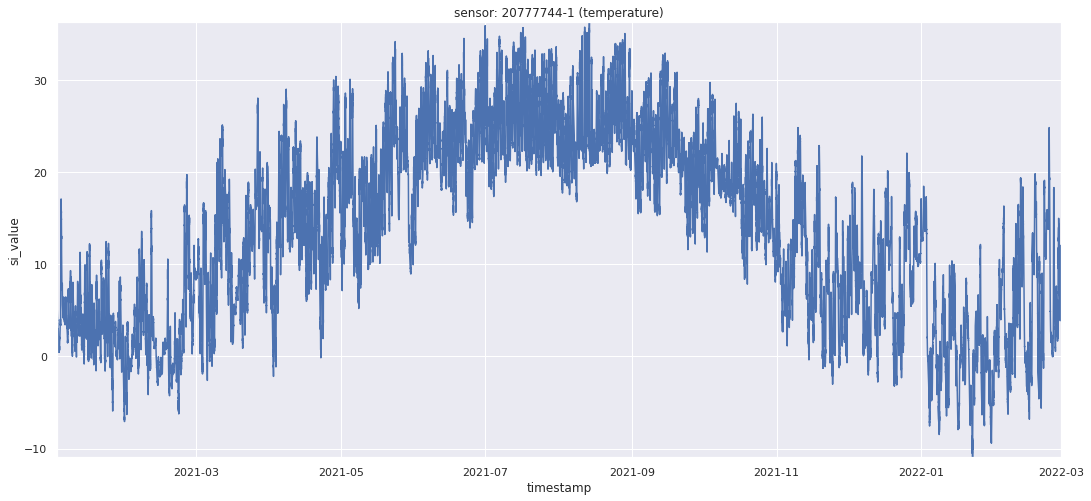

In [39]:
graph = sns.lineplot(x='timestamp', y='si_value', data=df)
graph.set(xlim=(df['timestamp'].min(), df['timestamp'].max()), 
          ylim=(df['si_value'].min(), df['si_value'].max()),
          title=f'sensor: {sensor_id} (temperature)')

What if you want to limit the X axis on the graph above? Well, that is not a problem. Let's pick just 1 day to look into in more detail.

[(18910.0, 18910.996527777777),
 (16.701126386969733, 21.365717111939787),
 Text(0.5, 1.0, 'sensor: 20777744-1 (temperature)')]

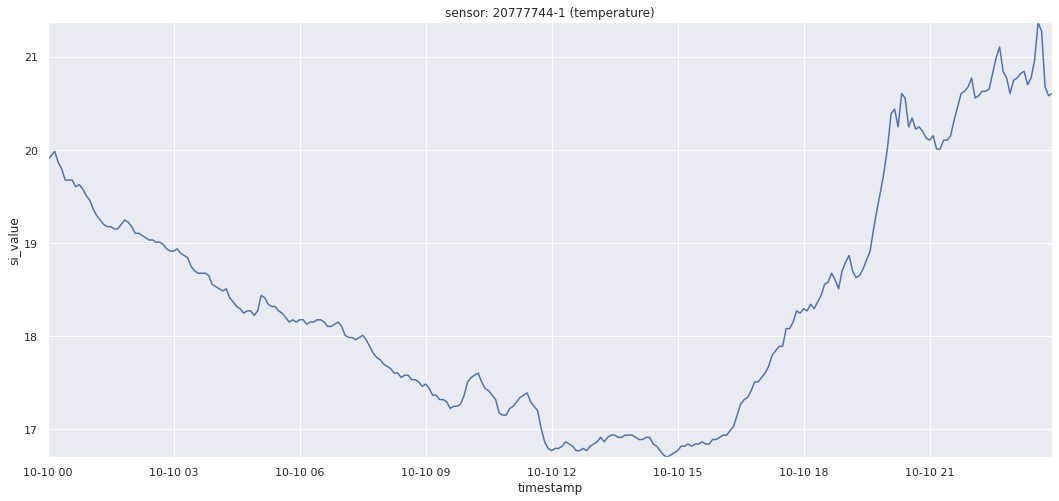

In [40]:
# Filter for a timeslice of the dataframe
sliced_df = df.loc[(df['timestamp'] >= '2021-10-10')
                    & (df['timestamp'] < '2021-10-11')]

# Then plot
graph = sns.lineplot(x='timestamp', y='si_value', data=sliced_df)
graph.set(xlim=(sliced_df['timestamp'].min(), sliced_df['timestamp'].max()), 
          ylim=(sliced_df['si_value'].min(), sliced_df['si_value'].max()),
          title=f'sensor: {sensor_id} (temperature)')

### 6.2. Plotting sensors of the same kind

In [41]:
# First, determine which measurement you want to query for
# For instance, 'soil conductivity', index #11
data_table = f["data"]
measurement_index = 7
query = f"measurement_type == {measurement_index}"
arr = data_table.read_where(query)
arr.shape

(474370,)

In [42]:
# Pass the array to a dataframe and display its first lines
df = pd.DataFrame(arr)
df.head()

logger_sn      sensor_sn  data_type_id  measurement_type  si_value  \
0  b'20778368'  b'20773519-1'             1                 7  0.269755   
1  b'20778368'  b'20773519-1'             1                 7  0.269755   
2  b'20778368'  b'20773519-1'             1                 7  0.269755   
3  b'20778368'  b'20773519-1'             1                 7  0.269755   
4  b'20778368'  b'20773519-1'             1                 7  0.269755   

    timestamp  
0  1609477200  
1  1609477500  
2  1609477800  
3  1609478100  
4  1609478400

In [43]:
# Convert the timestamps to strings
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Convert the byte string arrays into UTF-8 strings
df['logger_sn'] = [bytestr.decode('UTF-8') for bytestr in df['logger_sn']]
df['sensor_sn'] = [bytestr.decode('UTF-8') for bytestr in df['sensor_sn']]
df

logger_sn   sensor_sn  data_type_id  measurement_type  si_value  \
0       20778368  20773519-1             1                 7  0.269755   
1       20778368  20773519-1             1                 7  0.269755   
2       20778368  20773519-1             1                 7  0.269755   
3       20778368  20773519-1             1                 7  0.269755   
4       20778368  20773519-1             1                 7  0.269755   
...          ...         ...           ...               ...       ...   
474365  20778369  20778345-1             1                 7  0.059592   
474366  20778369  20778347-1             1                 7  0.076592   
474367  20778369  20773520-1             1                 7  0.314787   
474368  20778369  20778345-1             1                 7  0.057892   
474369  20778369  20778347-1             1                 7  0.076592   

                 timestamp  
0      2021-01-01 05:00:00  
1      2021-01-01 05:05:00  
2      2021-01-01 05:10:00  
3      2021-01-01 05:15:00  
4      2021-01-01 05:20:00  
...                    ...  
474365 2022-03-01 04:50:00  
474366 2022-03-01 04:50:00  
474367 2022-03-01 04:55:00  
474368 2022-03-01 04:55:00  
474369 2022-03-01 04:55:00  

[474370 rows x 6 columns]

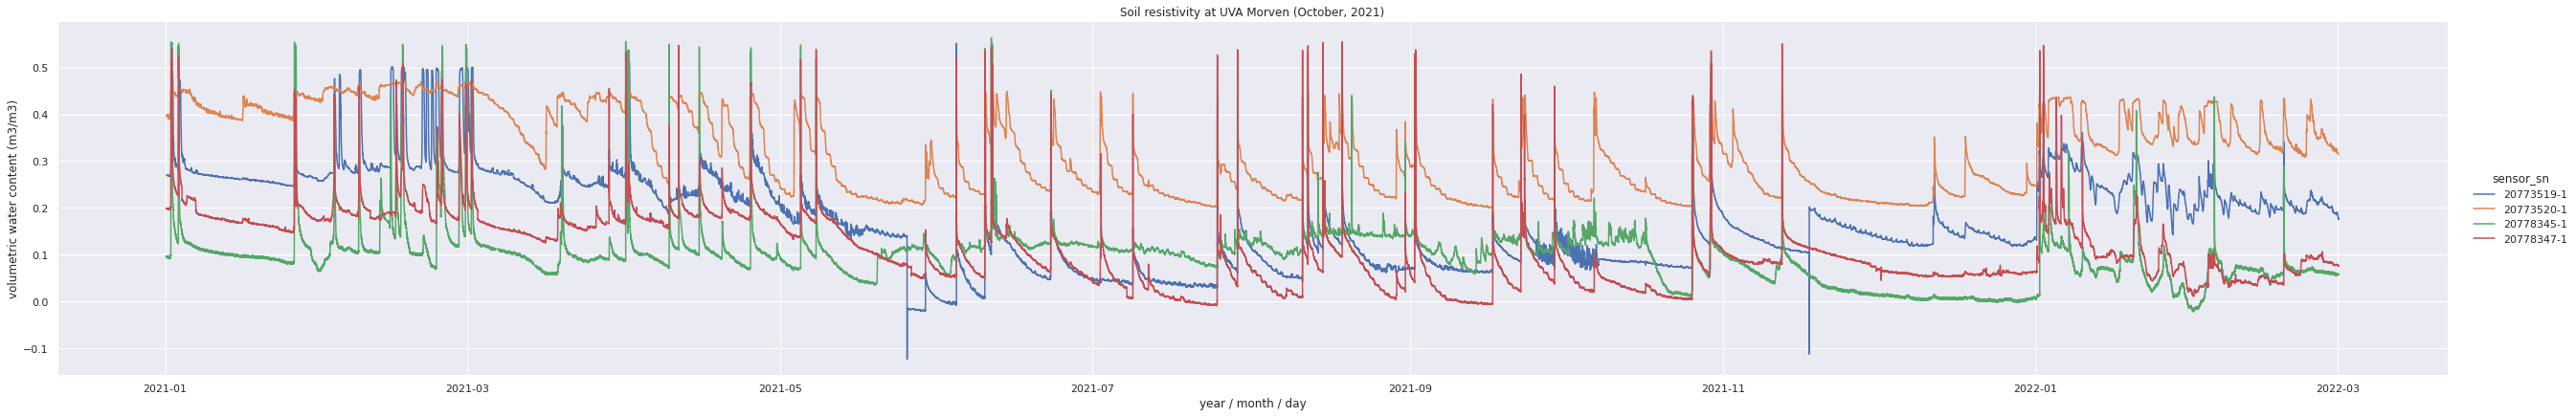

In [44]:
graph = sns.relplot('timestamp', 'si_value', hue='sensor_sn', kind='line', linewidth=1.5, data=df, height=6, aspect=6)
graph.set(xlabel='year / month / day',
          ylabel='volumetric water content (m3/m3)',
          title='Soil resistivity at UVA Morven (October, 2021)')

### 6.2. Stacking sensors of the same kind

Sometimes it is easier to read the timeseries if they are stacked, instead of combined in the same graph or staggered. Here is how to do it:

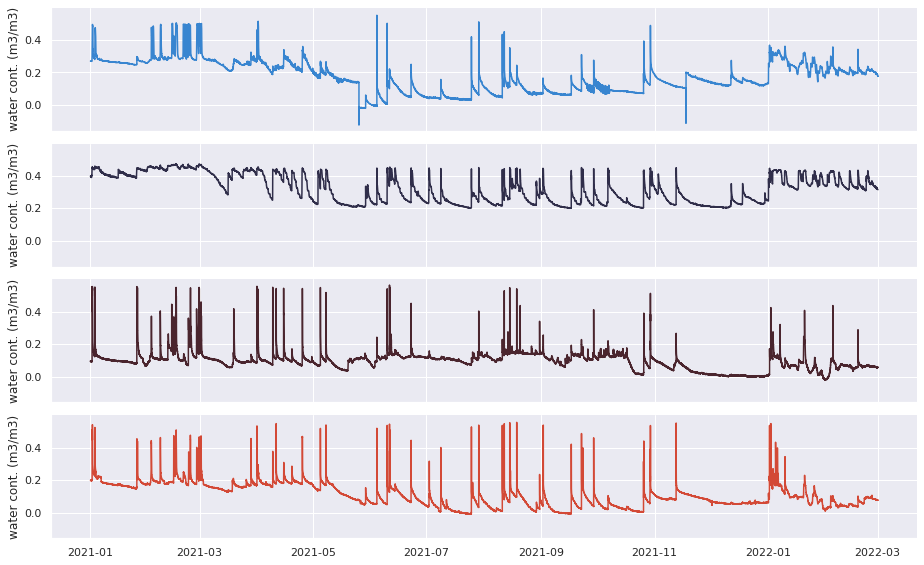

In [45]:
graph = sns.relplot(x='timestamp', 
                    y='si_value', 
                    col='sensor_sn', 
                    hue='sensor_sn', 
                    data=df,
                    kind='line',
                    linewidth=1.5,
                    palette='icefire', 
                    col_wrap=1,
                    legend=False, 
                    height=2, 
                    aspect=6.5)
# Tweak the supporting aspects of the plot
graph.set_titles("")
graph.set_axis_labels("", "water cont. (m3/m3)")
graph.tight_layout()

### 6.3. Exploring seasonality, trends, and residuals (TBD)

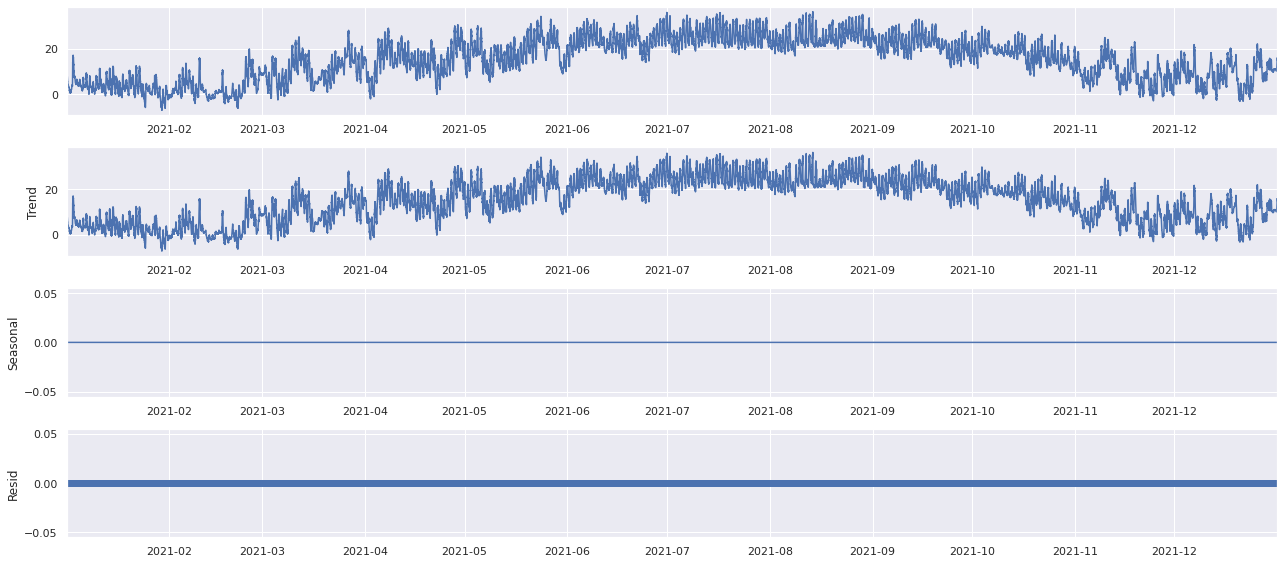

In [46]:
# First, import 'statsmodels'
from statsmodels.tsa.seasonal import seasonal_decompose

# Then, query for the timeseries we want to explore
# Say, one of the temperature sensors
# Or, the mean of all of them
sensor_id = '20777744-1'
query = f"sensor_sn == b'{sensor_id}'"
arr = data_table.read_where(query)
df = pd.DataFrame(arr)

# Prepare dataframe for decomposition function
df.drop(['logger_sn', 'sensor_sn', 'data_type_id', 'measurement_type'], axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

# Select just one year, say 2021 ... or 2022?
df = df['2021'].dropna()

# Run the seasonal decomposition
results = seasonal_decompose(df, period=1)

# And plot!
results.plot(); # <---
# Lil' Jupyter hack: semi-colon prevents returned output from being evaluated
# This is necessary from preventing the plot to be shown twice...

### 6.4. Exploring correlations (TBD)

We want to explore relationships between sensors and measurements. As a preliminary step we can plot a correlation matrix in textual format, but also as a heatmap to facilitate reading. Let's use all the sensors at Morven of a particular measurement (ground temperature) and of a particular model (THC):

Text(0, 0.5, 'sensor_sn: 20779619-1')

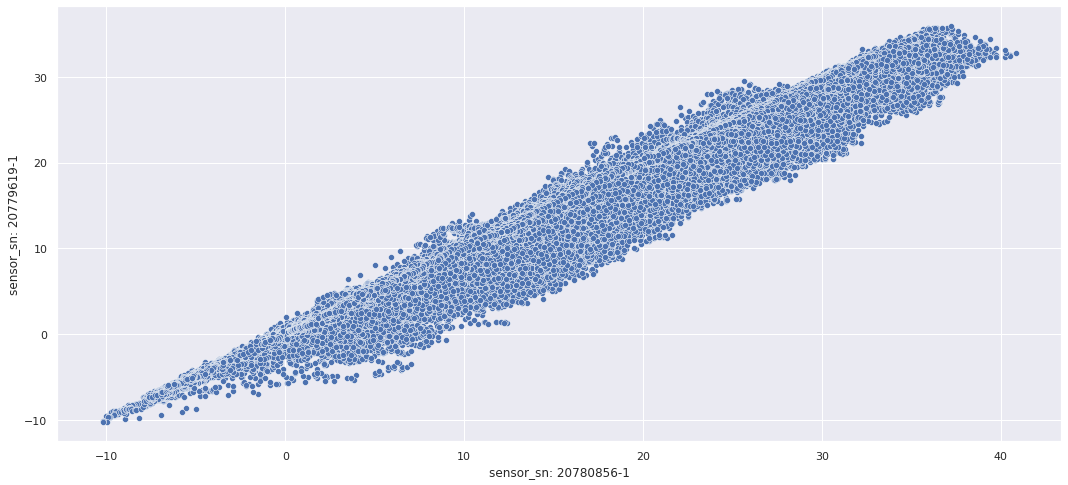

In [47]:
# Query for a sensor
sensor_id = '20780856-1'
query = f"sensor_sn == b'{sensor_id}'"
arr = data_table.read_where(query)
df = pd.DataFrame(arr)

# Query for a second sensor
sensor_id = '20779619-1'
query = f"sensor_sn == b'{sensor_id}'"
arr = data_table.read_where(query)
df2 = pd.DataFrame(arr)

# Correlate!
corr = df['si_value'].corr(df2['si_value'])
corr

# Plot correlation
graph = sns.scatterplot(df['si_value'], df2['si_value'])
plt.xlabel('sensor_sn: 20780856-1')
plt.ylabel('sensor_sn: 20779619-1')

#### 6.4.1. Autocorrelations (TBD)

This will be particularly useful in the future for feature selection: it helps us explore recurrent patterns.

In [48]:
#from pandas.plotting import autocorrelation_plot
# TBD

### 6.5. Anomaly detection (TBD)

In [49]:
#from luminol.modules.time_series import TimeSeries
#from luminol.anomaly_detector import AnomalyDetector

# Query for sensor data
#sensor_id = '20778337-1'
#query = f"sensor_sn == b'{sensor_id}'"
#arr = data_table.read_where(query)
#df = pd.DataFrame(arr)

# Prepare dataframe to be converted to luminol-ts
#df = df.loc[:, 'si_value':'timestamp']
#df = df[['timestamp', 'si_value']]

# Create a dictionary for luminol-ts input
#df = df.set_index('timestamp').to_dict()
#df

#detector = luminol.anomaly_detector.AnomalyDetector(ts)
#anomalies = detector.get_anomalies()
#anomalies

## 7. Using R (instead of Python) to analyze a dataframe

Here is a demonstration of the beauty of Jupyter notebooks: you have tons of flexibility. Once you have a Pandas dataframe object (declared 'df' in the previous section), it is trivial to switch to R with one line of code.

But... before we get to that magical line, we need to perform one conversion that R does not like: our strings (in byte string format from Numpy) need to be converted to UTF-8 strings that R expects. So, let's recap the previous section:

In [50]:
# Let's pick a sensor by serial number
sensor_id = '20777744-1'

# RH sensor
sensor_id = '20777744-2'

# Let's built an array with the data from that sensor
query = f"sensor_sn == b'{sensor_id}'"
arr = data_table.read_where(query)

# Let's use that array to create a dataframe
df = pd.DataFrame(arr)

# Let's convert the timestamps to strings
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

# Let's convert the byte string arrays into UTF-8 strings
df['logger_sn'] = [bytestr.decode('UTF-8') for bytestr in df['logger_sn']]
df

logger_sn      sensor_sn  data_type_id  measurement_type   si_value  \
0       20778368  b'20777744-2'             1                 2  75.199997   
1       20778368  b'20777744-2'             1                 2  75.899997   
2       20778368  b'20777744-2'             1                 2  76.599997   
3       20778368  b'20777744-2'             1                 2  76.799997   
4       20778368  b'20777744-2'             1                 2  76.799997   
...          ...            ...           ...               ...        ...   
118951  20778368  b'20777744-2'             1                 2  39.799998   
118952  20778368  b'20777744-2'             1                 2  39.999998   
118953  20778368  b'20777744-2'             1                 2  40.599998   
118954  20778368  b'20777744-2'             1                 2  41.299998   
118955  20778368  b'20777744-2'             1                 2  41.099998   

                 timestamp  
0      2021-01-01 05:00:00  
1      2021-01-01 05:05:00  
2      2021-01-01 05:10:00  
3      2021-01-01 05:15:00  
4      2021-01-01 05:20:00  
...                    ...  
118951 2022-03-01 04:35:00  
118952 2022-03-01 04:40:00  
118953 2022-03-01 04:45:00  
118954 2022-03-01 04:50:00  
118955 2022-03-01 04:55:00  

[118956 rows x 6 columns]

Looks good, let's convert the other column with sensor serial numbers as well:

In [51]:
df['sensor_sn'] = [bytestr.decode('UTF-8') for bytestr in df['sensor_sn']]
df

logger_sn   sensor_sn  data_type_id  measurement_type   si_value  \
0       20778368  20777744-2             1                 2  75.199997   
1       20778368  20777744-2             1                 2  75.899997   
2       20778368  20777744-2             1                 2  76.599997   
3       20778368  20777744-2             1                 2  76.799997   
4       20778368  20777744-2             1                 2  76.799997   
...          ...         ...           ...               ...        ...   
118951  20778368  20777744-2             1                 2  39.799998   
118952  20778368  20777744-2             1                 2  39.999998   
118953  20778368  20777744-2             1                 2  40.599998   
118954  20778368  20777744-2             1                 2  41.299998   
118955  20778368  20777744-2             1                 2  41.099998   

                 timestamp  
0      2021-01-01 05:00:00  
1      2021-01-01 05:05:00  
2      2021-01-01 05:10:00  
3      2021-01-01 05:15:00  
4      2021-01-01 05:20:00  
...                    ...  
118951 2022-03-01 04:35:00  
118952 2022-03-01 04:40:00  
118953 2022-03-01 04:45:00  
118954 2022-03-01 04:50:00  
118955 2022-03-01 04:55:00  

[118956 rows x 6 columns]

After all of this preliminary hoops we finally get to the **magic** command that will take us straight to R-land:

In [52]:
%R -i df

In [53]:
%R str(df)

'data.frame':	118956 obs. of  6 variables:
 $ logger_sn       : chr  "20778368" "20778368" "20778368" "20778368" ...
 $ sensor_sn       : chr  "20777744-2" "20777744-2" "20777744-2" "20777744-2" ...
 $ data_type_id    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ measurement_type: int  2 2 2 2 2 2 2 2 2 2 ...
 $ si_value        : num  75.2 75.9 76.6 76.8 76.8 ...
 $ timestamp       : POSIXct, format: "2021-01-01 05:00:00" "2021-01-01 05:05:00" ...


In [54]:
%R print(summary(df['si_value']))

    si_value     
 Min.   : 15.70  
 1st Qu.: 48.50  
 Median : 63.70  
 Mean   : 65.71  
 3rd Qu.: 85.30  
 Max.   :100.00  


<rpy2.robjects.vectors.StrMatrix object at 0x7efe77ff8d80> [RTYPES.STRSXP]
R classes: ('table',)
['Min...., '1st ..., 'Medi..., 'Mean..., '3rd ..., 'Max....]

In [55]:
%R print(head(df))

  logger_sn  sensor_sn data_type_id measurement_type si_value
0  20778368 20777744-2            1                2     75.2
1  20778368 20777744-2            1                2     75.9
2  20778368 20777744-2            1                2     76.6
3  20778368 20777744-2            1                2     76.8
4  20778368 20777744-2            1                2     76.8
5  20778368 20777744-2            1                2     77.4
            timestamp
0 2021-01-01 05:00:00
1 2021-01-01 05:05:00
2 2021-01-01 05:10:00
3 2021-01-01 05:15:00
4 2021-01-01 05:20:00
5 2021-01-01 05:25:00


rec.array([('20778368', '20777744-2', 1, 2, 75.19999664, 1.6094772e+09),
           ('20778368', '20777744-2', 1, 2, 75.8999966 , 1.6094775e+09),
           ('20778368', '20777744-2', 1, 2, 76.59999657, 1.6094778e+09),
           ('20778368', '20777744-2', 1, 2, 76.79999656, 1.6094781e+09),
           ('20778368', '20777744-2', 1, 2, 76.79999656, 1.6094784e+09),
           ('20778368', '20777744-2', 1, 2, 77.39999654, 1.6094787e+09)],
          dtype=[('logger_sn', '<U8'), ('sensor_sn', '<U10'), ('data_type_id', '<i4'), ('measurement_type', '<i4'), ('si_value', '<f8'), ('timestamp', '<f8')])

Let's create another dataframe with only sensor values:

In [56]:
%R df_numeric <- df[-c(1:4, 6)]

rec.array([(75.19999664,), (75.8999966 ,), (76.59999657,), ...,
           (40.59999818,), (41.29999815,), (41.09999816,)],
          dtype=[('si_value', '<f8')])

In [57]:
# Import required R packages
%R library(repr)
%R library(ggplot2)
%R library(scales)
warnings.filterwarnings('ignore')

Science: https://r4ds.had.co.nz/



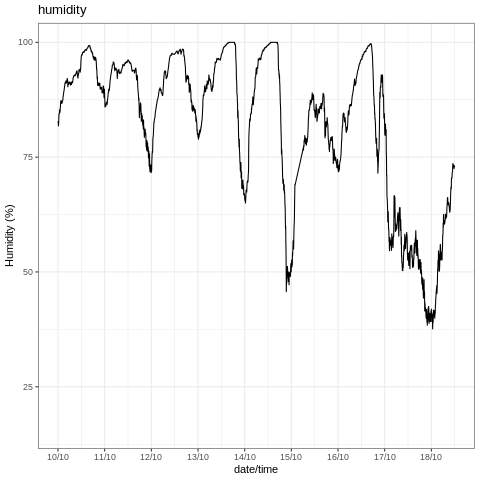

<rpy2.robjects.vectors.StrVector object at 0x7f010049d8c0> [RTYPES.STRSXP]
R classes: ('character',)
['test.png']

In [58]:
# Set-up plot size
%R options(repr.plot.width = 80, repr.plot.height = 30)

# Select time slice
%R start_time <- as.POSIXct('2021-10-10 00:00:00')
%R end_time <- as.POSIXct('2021-10-18 12:00:00')
%R start.end <- c(start_time,end_time)

# Plot it!
%R g <- ggplot(data = df, aes(x = timestamp, y = si_value)) + \
               geom_line() + \
               theme_bw() + \
               scale_x_datetime(limits=start.end, \
                                breaks=date_breaks('1 day'), \
                                labels=date_format('%d/%m')) + \
               labs(title = 'humidity', \
                     x = 'date/time', \
                     y = 'Humidity (%)')
%R print(g)
%R ggsave("test.png", g, width=15, height=10)

## 7.1. Anomaly detection with R

In [59]:
# Rewrite our data frame with the original array we queried for
#df = pd.DataFrame(arr)

# Load the dataframe with R
#%R -i df

In [60]:
#%R library(AnomalyDetection)

In [61]:
# Install the necessary package
# Uncomment this line if running for the first time
#%R install.packages('AnomalyDetection')

In [62]:
#%R library(AnomalyDetection)

## 8. Data integrity

Below we run a check to see how many data points are missing from the data store in the past 2 hours. These missing data points are due to a difference in the sampling rate of different metrics: battery level data for individual motes is updated less frequently, for example.

In [63]:
# Get last 2 hour of data from the cluster
now = int(time.time())
then = now -  2 * 60 * 60

# Create an array with the data from the last 2 hours
arr = data_table.read_where(f"timestamp > {then}")
arr.shape

# Check for gaps in the timestamp
ts_last = None
count = 0
for i in range(arr.shape[0]):
    e = arr[i]
    ts = e['timestamp']
    if ts_last != None and ts - ts_last != 300:
        print(f"{i}: last: {ts_last} this: {ts} ")
        count += 1
    ts_last = ts
print(f"missing {count} values")

missing 0 values


## License

[CC-BY-SA 2022]: John Readey, LF Murillo

**Last updated:** March 31, 2021